# Diffusion Models
## Theory


![diff](../resources/images/diff.png)

To understand the essence of diffusion models, let us first consider a conspicuously llama-shaped cloud suspended in a room. This cloud is the outcome of some unknown generative process. After its formation, the particles that compose this cloud will begin to jitter randomly, causing the shape to gradually dissipate. While we can't possibly evaluate the precise trajectory of any individual particle, we can describe their evolution probabilistically - at each step, there exists a distribution over particle displacements that depends only on their current configuration. 

Now suppose that, rather than allowing this dissipation to occur naturally, we deliberately define the stochastic rule governing how this cloud evolves. At each step, we inject noise according to a known distribution, chosen such that after sufficiently many steps, the cloud reaches a simple and predictable terminal distribution. This defines a forward stochastic process that progressively destroys structure whilst remaining analytically tractable. 

The central question, then, of diffusion models is not whether we can reverse individual particle trajectories, but whether we can define a stochastic reverse process whose induced distributions recover the original data, starting from the known terminal distribution. Let's start by formalising the problem. 

This cloud, $x_0$, has been formed as a result of an underlying generative process that forms a distribution, $q(x_0)$, over every possible shape that can be generated by this process. While we cannot possibly hope to learn the underlying generative process, it is possible to approximate the distribution that it implies so that we may sample new data from it.

We see in the above image how the distribution of data at each subsequent step is dependent only on the current step: the cloud-shaped llama at $t+1$ is a slightly distorted version of the cloud-shaped llama at time $t$. In other words, the evolution of the distribution is such that the state at $t+1$ depends only on the state at time $t$ - i.e., $q(x_t|x_{t-1})$. Under this assumption, the process is **Markovian** and can be represented as a **Markov chain**. Each perturbation step is governed by a **Markov transition kernel**, $K(x_{t+1}|x_t)$ which specifies a conditional distribution over possible next states given the current state:
$$q(x_{t+1})=\int K(x_{t+1}|x_t)\cdot q(x_t)\text{ }dx_t$$
When this stochastic transition is applied across the data distribution, the uncertainty it introduces leads to a gradual smoothing of the density function, destroying the fine structure in the data and causing the distribution to become increasingly diffuse. This transition kernel describes the **forward process**:
$$x_{t+1}\sim K(x_{t+1}|x_t).$$

So far, we have described the forward dynamics of a diffusion process: a Markovian evolution that progressively destroys fine-scale structure in the data. Nevertheless, we observe that if the corresponding **reverse-time dynamics** could be modelled, then the diffusion process could be repurposed as a generative model: by starting from a simple, highly diffused distribution, samples could progressively be transformed back into realistic data by simulating this reverse process. This requires three ingredients:
1. A simple, known distribution that approximates the terminal state of the forward process;
2. a reverse-time transition kernel that describes how samples evolve backwards through time; 
3. and a learnable parameterisation of the reverse-time dynamics.

In practice, we will choose a simple reference distribution, $p_T(x)$, that is easy to sample from. The forward process is defined, through the choice of kernel and its hyperparameters, so that after sufficient steps, $x_T$ is approximately distributed according to this reference distribution:
$$q(x_T)\approx p_T(x)$$
Most commonly, an isotropic Gaussian, $p_T(x)=N(0, I)$, is chosen as the reference distribution. Intuitively, the forward process progressively corrupts the data until it approximately resembles Gaussian noise.

Next, we need a reverse-time transition kernel, $x_{t-1}\sim T(x_{t-1}|x_t)$, that induces a backwards evolution of the marginal distributions, starting from the reference distribution at $t=T$:
$$p_{t-1}(x_{t-1})=\int T(x_{t-1}|x_t)\cdot p_t(x_t)\text{ }dx_t$$
In principle, this kernel should correspond to the true time-reversal of the forward diffusion process (i.e., given the current state, what is the distribution over all possible states at the preceding step that could have led to it?). However, this reverse-time conditional cannot be evaluated in closed form, as it depends on the unknown data distribution. To see why, we can derive it explicitly from the forward process. 

If the reverse process is to exactly invert the forward process in distribution, then its transitions need to match the conditional distribution induced by the forward dynamics. Therefore, the reverse-time transition kernel must be equal to the reverse conditional of the forward process:
$$T(x_{t-1}|x_t)=q(x_{t-1}|x_t)$$

To obtain that, we can use the definition of a conditional distribution:
$$q(x_{t-1}|x_t)=\frac{q(x_{t-1}, x_t)}{q(x_t)}$$

To obtain the joint distribution $q(x_{t-1}, x_t)$, we first re-visit our forward process. The joint distribution across an entire forward trajectory $x_{0:T}$ factorises as
$$q(x_{0:T})=q(x_0)\prod_{t=1}^T K(x_t|x_{t-1})$$
By taking that result, we can marginalise out everything except $(x_{t-1}, x_t)$ to give:
$$q(x_{t-1}, x_t) = q(x_{t-1}) \cdot K(x_t|x_{t-1})$$
Substituting back into our earlier expression, we can yield a definition for our reverse-time transition kernel:
$$q(x_{t-1}|x_t)=\frac{q(x_{t-1}) \cdot K(x_t|x_{t-1})}{q(x_t)}$$
While the forward kernel $K$ is known (we define it), the intermediate marginals $q(x_{t-1})$ and $q(x_t)$ are only defined through repeated application of the forward process to real data. Since the data distribution $q(x_0)$ is unknown and accessible only through samples - i.e., we do not know its functional form - the intermediates cannot be evaluated pointwise, meaning that for a given value $\tilde{x_t}$, we cannot compute $q(x_t=\tilde{x_t})$ (the marginal density of $x_t$) and consequently the conditional $q(x_{t-1}|x_t=\tilde{x_t})$.  Thus, the true reverse-time kernel is intractable. What can we do instead?

Diffusion models address this by introducing a parameterised approximation to the intractable reverse-time kernel, which is trained to match the true reverse dynamics induced by the forward process.

## Approximating the Reverse-Time Process
### Defining the forward process
Let's begin by specifying the forward process kernel $K(x_{t+1}|x_t)$. As discussed earlier, the role of the forward process is to progressively corrupt the data distribution until it approximately resembles a simple reference distribution. For this reference distribution to be useful in a generative setting, it should be known, tractable, and easy to sample from.

The standard multivariate Gaussian emerges as a natural choice. Accordingly, we design the forward process such that after sufficiently many steps, the marginal distribution of $x_T$ is approximately
$$q(x_T)\approx \mathcal{N}(0,I).$$

To do this, we define a forward transition kernel that slowly corrupts the current state with Gaussian noise at each step. We must consider that:
1. We want to inject noise at each step;
2. and the scale of $x_T$ must be controlled.
The second point requires that while we **add** noise to $x_t$, we must also gradually **attenuate** it too. Without attenuation, noise would accumulate across steps leading to a random walk that takes us far from the fixed end-point we had hoped to eventually sample from. 

A simple forward kernel that satisfies these criteria can be written in the linear Gaussian form:
$$x_{t}=ax_{t-1} + b\epsilon_t, \quad \epsilon\sim\mathcal{N}(0,I)$$
where $a$ and $b$ are constants that control attenuation and noise injection respectively. At each step, some of the original signal is removed and an amount of noise is added.

To ensure that the standard Gaussian distribution is a stable fixed point of the forward process, we require that if $x_{t-1}\sim\mathcal{N}(0,I)$, then the resulting variable $x_t$ is also distributed as $\mathcal{N}(0,I)$. Under this condition, the variance of $x_t$ 

$$
\begin{align}
\text{Var}(x_t)&=\text{Var}(ax_{t-1}+b\epsilon_t)\\
&=a^2\text{Var}(x_{t-1})+b^2\text{Var}(\epsilon_t)\\
&=a^2+b^2,
\end{align}
$$
satisfies (recalling that the standard Gaussian has a variance of 1) the constraint
$$a^2+b^2=1$$
and so
$$
\begin{align}
a=\sqrt{1-b^2}\\
b=\sqrt{1-a^2}
\end{align}
$$
In practice, we define a single scalar for both $a$ and $b$, referred to as $\beta$:
$$
a=\sqrt{1-\beta},\quad
b=\sqrt{\beta}.
$$

Thus, we yield the final parameterisation of the forward step:
$$x_t=\sqrt{1-\beta}\cdot x_{t-1}+\sqrt{\beta}\cdot \epsilon_t,\quad\epsilon\sim\mathcal{N}(0,I)$$
This implicitly defines our forward kernel:
$$K(x_{t}|x_{t-1})=\mathcal{N}(\sqrt{1-\beta}x_{t-1}, \beta_t I).$$





### Re-conditioning the problem
While this forward kernel specifies how noise is injected locally at each step, it does not describe the cumulative effect of repeatedly applying this process. In particular, it does not by itself explain how successive transitions transform a complex data-generating distribution into a simple multivariate Gaussian. 

To understand how the forward diffusion behaves globally, we can examine how a noisy state at an arbitrary time step $x_t$ relates to the original data point $x_0$. Doing so will allow us to describe the effect of the forward process after $t$ steps in a single expression without simulating intermediate transitions - i.e., it allows us to reason about the conditional distribution $q(x_t|x_0)$. 

Importantly, this gives us insight into the forward process *irrespective of any intractable data distributions*. This switches the question from 'What does the data look like after corruption?' ($q(x_t)$ - intractable) to 'What happens to a specific data point when I corrupt it?' ($q(x_t|x_0)$ - tractable). Once we begin to understand this relationship, we can begin to reason about how such corruption may be systematically undone. 

Using a Gaussian kernel allows us to do something interesting. Any linear transformation of a Gaussian distribution is itself Gaussian. That means that we can sample $x_t$ at an arbitrary timestep $t$ in closed form. 

Firstly, we define
$$\alpha \doteq 1-\beta,$$
and the cumulative product
$$\bar{\alpha}_t\doteq \prod_{s=1}^t \alpha_s.$$
We can then begin to unroll our Markov chain. For $t=1$:
$$x_1=\sqrt{\alpha_1}x_0+\sqrt{1-\alpha_1}\epsilon_1$$
Substituting into $t=2$:
$$
\begin{align}
x_2=\sqrt{\alpha_2}(\sqrt{\alpha_1}x_0+\sqrt{1-\alpha}\epsilon_1)+\sqrt{1-\alpha_2}\epsilon_2\\
x_2=\sqrt{\alpha_2\alpha_1}x_0 + \underbrace{\sqrt{\alpha_2(1-\alpha_1)}\epsilon_1 + \sqrt{1-\alpha_2}\epsilon_2}_{\text{Sum of Gaussians}}
\end{align}
$$
Note that the coefficient on $x_0$ is $\sqrt{\alpha_1\alpha_2}=\sqrt{\bar{\alpha}_2}$, and the noise is now a sum of differently-scaled independent Gaussians. This gives us the obvious generalised coefficient for $x_0$, $\sqrt{\bar{\alpha}_t}$, and the noise coefficient $\sqrt{1-\bar{\alpha}_t}$. With this information, we can generate $x_t$ at an arbitrary timestep:
$$x_t=\sqrt{\bar{\alpha}_t}x_0 + \sqrt{1-\bar{\alpha}_t}\epsilon$$

Earlier, we proposed that a generative model could be defined by reversing the noising process. Given the forward transition $q(x_t|x_{t-1})$, we would like to compute the corresponding reverse conditional $q(x_{t-1}|x_t)$ - that is, what data at time $t-1$ could have reasonably produced the observed noisy sample $x_t$. We also discussed how this reverse distribution was intractable because it depends on the marginal density $q(x_t)$, which is defined implicitly through the unknown data-generating distribution $q(x_0)$. 

However - what if we *did* have a sample from $q(x_0)$? If we had access to the original data, and we see what the noised version looks like at time $t$, could we reason about what it could have looked like at time $t-1$? As it transpires, under the Gaussian forward process, this conditional distribution $q(x_{t-1}|x_t, x_0)$ *is* analytically tractable.

Conditioning on the original data point $x_0$ transforms the problem into a simple linear-Gaussian inference task. Under the forward process, $x_{t-1}$ is obtained by a linear transformation plus Gaussian noise, and $x_t$ is obtained from $x_{t-1}$ by another linear Gaussian transformation. As a result, the joint distribution of $(x_{t-1}, x_t)$ conditioned on $x_0$ is a multivariate Gaussian, and so it follows that the conditional distribution $q(x_{t-1}|x_t, x_0)$, obtained by conditioning one Gaussian variable on another, is itself Gaussian. 

A standard property of Gaussian conditioning is that the conditional mean is an affine function of the variables being conditioned on. Consequently, the mean of $q(x_{t-1}|x_t, x_0)$, $\tilde{\mu}_t$ is a linear combination of the noisy sample $x_t$ and the original data point $x_0$. Since the covariance is fully specified by the noise schedule, the corresponding conditional variance $\tilde{\beta}_tI$ is a deterministic function of that schedule. Thus we can construct:
$$q(x_{t-1}|x_t, x_0)=\mathcal{N}(\tilde{\mu}_t(x_t, x_0), \tilde{\beta}_t I)$$

The closed-form expressions for both the posterior mean $\tilde{\mu}_t$ and variance $\tilde{\beta}_t$ can readily be derived by virtue of Gaussian algebra to yield:
$$
\tilde{\mu}_t(x_t, x_0)=\frac{\sqrt{\alpha_t}(1-\bar{\alpha}_{t-1})}{1-\bar{\alpha}_t}x_t + \frac{\beta_t\sqrt{\bar{\alpha}_{t-1}}}{1-\bar{\alpha}_t}x_0, \quad
\tilde{\beta}_t = \frac{1-\bar{\alpha}_{t-1}}{1-\bar{\alpha}_t}\beta_t.
$$

An observant reader may note that while this construction allows us to derive an exact reverse transition given access to the original data point $x_0$, the purpose of a generative model is precisely to produce new samples for which no such data point exists. At generation time, we observe only the noisy sample $x_t$, and the conditional distribution $q(x_{t-1}|x_t, x_0)$ cannot be evaluated directly. 

However, we have identified a tractable conditional distribution that characterises the true reverse dynamics of the diffusion process when the original data point is known. The remaining question, then, is how to construct a generative model that can approximate these dynamics *without access to $x_0$*.



### Defining a generative model
Let's first consider what our generative model is: a reversed Markov chain
$$p_\theta(x_0,...,x_T)=p(x_T)\prod_{t=1}^Tp_\theta(x_{t-1}|x_t).$$

Ultimately, we want to model
$$p_\theta(x_0)\approx q(x_0).$$
Which involves maximising
$$\log p_\theta(x_0)$$
where
$$p_\theta(x_0)=\int p_\theta(x_0, x_{1:T})dx_{1:T}.$$
This marginal likelihood is defined through a latent variable model with $T$ intermediate states, obtained by marginalising over all possible reverse-time trajectories that could produce $x_0$ - as a result, learning concerns the **entire reverse process**, not just one isolated transition. Optimising just one reverse step $p_\theta(x_{t-1}|x_t)$ in isolation does not provide any guarantee that the chain composes into a coherent global generative model. Maximising the marginal likelihood therefore requires aligning the joint reverse-time trajectory distribution induced by $p_\theta$ with that of the reverse trajectory distribution implied by the forward process. However, we must also consider that integrating over all possible reverse-time trajectories is intractable as it operates over a very high dimensional space, and so we cannot directly maximise $\log p_\theta(x_0)$. 

Instead, we turn to **variational inference** and optimise $\log p_\theta(x_0)$ via a tractable **lower bound**. Generally, variational inference proceeds by firstly selecting a family of simple, tractable distributions such as Gaussians and introducing such a distribution to approximate the true distribution by adjusting its parameters. In diffusion, we set this variational distribution to the corresponding forward process, $q(x_{1:T}|x_0)$ (note that it must be conditioned on the particular value of $x_0$). Using this distribution, we can then rewrite the marginal likelihood as an expectation, allowing us to estimate the integral via sampling
$$
\begin{align}
p_\theta(x_0)&=\int p_\theta(x_0, x_{1:T})dx_{1:T}\\
&=\int q(x_{1:T}|x_0) \frac{p_\theta(x_0, x_{1:T})}{q(x_{1:T}|x_0)}dx_{1:T}\\
&=\mathbb{E}_{q(x_{1:T}|x_0)}\left[\frac{p_\theta(x_0, x_{1:T})}{q(x_{1:T}|x_0)}\right]
\end{align}
$$

We then take the logarithm of this expectation
$$
\log p_\theta(x_0)=\log \mathbb{E}_{q(x_{1:T}|x_0)}\left[\frac{p_\theta(x_0, x_{1:T})}{q(x_{1:T}|x_0)}\right]
$$
and then introduce Jensen's inequality, which states that for any convex function $f$:
$$\mathbb{E}[f(X)]\geq f(\mathbb{E}[X])$$

Since the logarithm is a concave function, Jensen's inequality implies
$$
\log p_\theta(x_0)\geq \mathbb{E}_{q(x_{1:T}|x_0)} \left[\log p_\theta(x_0, x_{1:T}) - \log q(x_{1:T}|x_0)\right].
$$ 
This quantity is known as the **Evidence Lower Bound (ELBO)**. Maximising the ELBO with respect to the parameters $\theta$ therefore increases a lower bound on the true data log likelihood $\log p_\theta(x_0)$, which allows us to train the model without directly evaluating the intractable integral. Importantly, the ELBO is an objective over entire latent trajectories $x_{1:T}$, thus matching distributions and ensuring coherence over the full reverse-time process. 

We derive the specific form of the ELBO as follows. Firstly, we expand both the model joint $p_\theta(x_0, x_{1:T})$ and the variatonal distribution $q(x_{1:T}|x_0)$. Taking the model joint:
$$
p_\theta(x_0,...,x_T)=p(x_T)\prod_{t=1}^T p_\theta(x_{t-1}|x_t)$$
And rewriting in $\log$ form:
$$
\log p_\theta(x_0, x_{1:T})=\log p(x_T)+\sum_{t=1}^T \log p_\theta(x_{t-1}|x_t)
$$
Similarly, we begin with the forward process:
$$q(x_{0:T})=q(x_0)\prod_{t=1}^T q(x_t|x_{t-1})$$
Note that the variational distribution is conditioned on $x_0$, and so is given by
$$q(x_{0:T}|x_0)=\prod_{t=1}^T q(x_t|x_{t-1}).$$
We then take the log form
$$\log q(x_{0:T}|x_0)=\sum_{t=1}^T \log q(x_t|x_{t-1}).$$

We can then substitute these forms to define the ELBO for one datapoint $x_0$:
$$\mathcal{L}(\theta;x_0)=\mathbb{E}_q\left[\log p(x_T)+\sum_{t=1}^T \log p_\theta(x_{t-1}|x_t) - \sum_{t=1}^T \log q(x_t|x_{t-1})  \right]$$

However, note that we have mixed elements of the forward process, $q(x_t|x_{t-1})$, with elements of the learned reverse process, $p_\theta(x_{t-1}|x_t)$. These terms condition on different variables and arise from different factorisations of the joint distribution (one from the forward, one from the reverse). As a result, they cannot be directly compared or combined into a meaningful divergence term, and the current objective doesn't represent a matching of reverse-time transitions. 

The reverse-time conditional of the forward process is given by:
$$q(x_{t-1}|x_t, x_0)=\frac{q(x_t|x_{t-1})q(x_{t-1}|x_0)}{q(x_t|x_0)}$$

We can rewrite this in terms of the forward kernel $q(x_{t}|x_{t-1})$:
$$
q(x_t|x_{t-1})=\frac{q(x_{t-1}|x_t,x_0)q(x_t|x_0)}{q(x_{t-1}|x_0)}
$$
And then take the logs:
$$\log q(x_t|x_{t-1}) = \log q(x_{t-1}|x_t, x_0) + \log q(x_t|x_0) - \log q(x_{t-1}|x_0)$$

And substituting it back into the ELBO to yield:
$$\mathcal{L}(\theta;x_0)=\mathbb{E}_q\left[\log p(x_T)+\sum_{t=1}^T \log p_\theta(x_{t-1}|x_t) - \sum_{t=1}^T \log q(x_{t-1}|x_t, x_0) + \log q(x_t|x_0) - \log q(x_{t-1}|x_0)\right]$$

Note that for $t=2,...T$, the terms $\log q(x_t|x_0)$ and  $- \log q(x_{t-1}|x_0)$ cancel telescopically (we are iteratively adding and subtracting the same value across timesteps), 
$$
\mathcal{L}(\theta;x_0)=\mathbb{E}_q\left[\log p(x_T)+\sum_{t=1}^T \log p_\theta(x_{t-1}|x_t) - 
\sum_{t=1}^T\log q (x_{t-1}|x_t, x_0) - 
\sum_{t=1}^T \log q(x_t|x_0) +
\sum_{t=1}^T\log q(x_{t-1}|x_0)
 \right] ,
$$
leaving only boundary terms at $t=1$ and $t=T$:
$$\sum_{t=1}^T\log q (x_{t-1}|x_t, x_0) - \sum_{t=1}^T\log q(x_{t-1}|x_0) = \log q(x_0|x_0)-\log q(x_T|x_0)= 1 - \log q(x_T|x_0)$$
$$
 \mathcal{L}(\theta;x_0)= \mathbb{E}_q\left[\log p(x_T) - \log q(x_T|x_0) +\sum_{t=1}^T \log p_\theta(x_{t-1}|x_t) - \sum_{t=1}^T (\log p_\theta(x_{t-1}|x_t)-\log q(x_{t-1}|x_t, x_0))
 \right]
$$

Now the ELBO directly compares reverse-time conditionals: the tractable reverse posterior $q(x_{t-1}|x_t, x_0)$ induced by the forward process, and the learned reverse transition $p_\theta(x_{t-1}|x_t)$. 

To convert this derivation into something we can actually use, we leverage the **Kullback-Leibler (KL) divergence**, which has the pattern:
$$KL(a||b)=\mathbb{E}_a[\log a - \log b]$$

To do this, we first need to reorganise our expectations so that they match that form. 

Firstly, we take the expectation under the boundary terms:
$$\mathbb{E}_q\left[\log p(x_T)-\log q(x_T|x_0)\right] = -KL\left(q(x_T|x_0)||p(x_T)\right)$$

For each $t$ inside the summation term, under the law of iterated expectation:
$$\mathbb{E}_q\left[\log p_\theta(x_{t-1}|x_t)-\log q(x_{t-1}|x_t, x_0)\right]=-\mathbb{E}_q(x_t|x_0)\left[KL(q(x_{t-1}|x_t,x_0)||p_\theta(x_{t-1}|x_t))\right]$$

However, note that at $t=1$, $q(x_0|x_1, x_0)$ is degenerate because we are conditioning on the variable we are predicting (i.e., a Dirac delta at the observed $x_0$), where
$$KL(\delta(x_0)||p_\theta(x_0|x_1))=-\log p_\theta(x_0|x_1) + \text{const}.$$
where the constant does not depend on $\theta$ and so can be dropped. 

This yields the **final ELBO loss**:
$$
\mathcal{L}(\theta; x_0)=\mathbb{E}_q
\left[
\underbrace{
    KL\left(q(x_T|x_0)||p(x_T)\right)
}_{\text{L}_T}
+
\underbrace{
    \sum_{t=2}^T KL(q(x_{t-1}|x_t,x_0)||p_\theta(x_{t-1}|x_t))
}_{\text{L}_{t-1}}
-
\underbrace{
    \log p_\theta(x_0|x_1)
}_{\text{L}_{0}}
\right]
$$

However, in practice, note that $L_T$ does not depend on $\theta$ - $q(x_T|x_0)$ is fully determined by the diffusion schedule and $p(x_T)$ is chosen in advance ($\mathcal{N}(0,I)$) - and so does not contribute to learning and can be safely dropped. 

### Denoising Diffusion Probabilistic Models
The original diffusion formulation, proposed by Sohl-Dickstein et al., introduced a parameterised reverse-time Markov kernel
$$p_\theta(x_{t-1}|x_t),$$
and trained it to match the analytically defined conditional $q(x_{t-1}|x_t, x_0)$ by minimising a KL divergence, averaged over data and forward trajectories. In the case of a Gaussian forward kernel, this corresponds to predicting a learned mean $\mu_\theta(x_t, t)$ and covariance of the reverse transition directly.

Ho et al. make a crucial simplifying observation: since the analytic reverse-step distribution is known up to its dependence on $x_0$, there is no need to learn the reverse dynamics from scratch. We can instead learn to predict $x_0$ itself from the noisy sample $x_t$, and then construct the reverse transition analytically using this prediction. Concretely, Ho et al. replace $x_0$ in $\tilde{\mu}_t(x_t, x_0)$ with a learned prediction $\hat{x}_0(x_t, t)$ and define the reverse-process mean by
$$\mu_\theta(x_t, t)\doteq \tilde{\mu}_t\left(x_t, \hat{x}_0(x_t, t)\right).$$
The reverse-time model is then parameterised as
$$p_\theta(x_{t-1}|x_t)=\mathcal{N}\left(x_{t-1}; \mu_\theta(x_t, t), \Sigma_\theta(x_t, t)\right),$$
where $\Sigma_\theta$ is often fixed to a value derived from the schedule such as $\tilde{\beta}_tI$ or $\beta_tI$ rather than being learned.

We can then use a function approximator (in this case, a neural network) to predict $\hat{x}_0$ given $x_t$ and $t$ as input, and then calculate the posterior mean as follows:
$$\mu_\theta(x_t, t)=\frac{\sqrt{\alpha_t}(1-\bar{\alpha}_{t-1})}{1-\bar{\alpha}_t}x_t + \frac{\beta_t\sqrt{\bar{\alpha}_{t-1}}}{1-\bar{\alpha}_t}\hat{x}_0(x_t, t),$$

To consider how this network will be trained, let's revisit the original objective - approximating the reverse-time kernel:
$$p_\theta(x_{t-1}|x_t)\approx q(x_{t-1}|x_t, x_0)$$

We want the distribution of our kernel to approach that of the true reverse-time kernel by adjusting the parameters $\theta$. Naturally, minimising the Kullback-Leibler divergence (KL) between our model and the true underlying presents a reasonable objective:
$$\mathcal{L}(\theta)\doteq\mathbb{E}_{t\sim\text{Uniform}\set{1,...,T}, x_0\sim q_\text{data}, \epsilon\sim\mathcal{N}(0,I)}\left[\text{KL}\left(q(x_{t-1}|x_t, x_0)||p_\theta(x_{t-1}|x_t)\right)\right]$$

A standard identity of the KL divergence between two Gaussian distributions with the same covariance is such that
$$KL\left(\mathcal{N}(\mu_q, \Sigma) || \mathcal{N}(\mu_p, \Sigma)\right) = \frac{1}{2}(\mu_p - \mu_q)^\intercal\Sigma^{-1}(\mu_p-\mu_q)$$
where $\Sigma=\tilde{\beta}_tI$ is fixed by the noise schedule, and $d$, the dimensionality, is fixed. 

Where $\Sigma^{-1}=\frac{1}{\tilde{\beta}_t}I$, $\mu_q=\tilde{\mu}_t(x_t, x_0)$, and $\mu_p=\mu_\theta(x_t, t)$, we can then define our objective function as follows:
$$\mathcal{L}(\theta)=\mathbb{E}\left[\frac{1}{2\tilde{\beta}_t}||\mu_\theta(x_t, t)-\tilde{\mu}_t(x_t, x_0)||^2\right]$$

Given that we know:
$$
\begin{align}
\tilde{\mu}_t(x_t, x_0)=A_tx_0 + B_tx_t \\
\mu_\theta(x_t, t)=A_t\hat{x}_0(x_t, t) + B_tx_t
\end{align}
$$
Then we can take the difference as:
$$
\mu_\theta-\tilde{\mu}_t=A_t(\hat{x}_0-x_0)+B_tx_t - B_tx_t = A_t(\hat{x}_0-x_0)
$$
And therefore our loss becomes:
$$
\begin{align}
\mathcal{L}(\theta)&=\mathbb{E}\left[\frac{1}{2\tilde{\beta}_t}||A_t(\hat{x}_0(x_t, t)-x_0)||^2\right]\\
&=\mathbb{E}\left[\underbrace{\frac{A^2_t}{2\tilde{\beta}_t}}_{w_t}||\hat{x}_0(x_t, t)-x_0||^2\right]
\end{align}
$$
Ho et al. observe empirically that the time-dependent weight $w_t$ leads to degraded sample quality, and so this term is generally dropped to yield a simplified objective
$$\mathcal{L}(\theta)=E\left[||\hat{x}_0(x_t, t)-x_0||^2\right]$$
However, let us now consider why predicting $x_0$ directly may be a poorly conditioned objective. Consider trying to predict an original image, $x_0$, with two separate noised samples - one at $t+1$ (one denoising step) and one at $t=T$ (terminal denoising step). With only a small amount of noise, $x_t$ still retains substantial information about $x_0$, and the associated uncertainty is low - the conditional $q(x_0|x_t)$ is sharply concentrated. Errors in predicting $x_0$ here reflect meaningful discrepancies between the model's estimate and the true data. 

Howver, when $t$ is large and $x_t$ is dominated by noise, very little of the signal from the original image is retained and the associated uncertainty is very high - $q(x_0|x_t)$ is very broad as many clean images are consistent with the same noisy sample. Errors in predicting $x_0$ at this level therefore arise largely from intrinsic uncertainty rather than from deficiencies in the model. 

Our regression objective, however, treats these prediction errors at both high and low noise as equally informative. This forces our model to devote capacity to resolving ambiguous predictions at large $t$ while assigning no special importance to errors in regimes where the signal is strong and errors are informative. As a result, optimisation becomes poorly conditioned as gradients are dominated by high-variance and low-information errors. While this could be resolved by introducing error weighting according to $t$, Ho et al. propose another solution. 

Let's re-visit the equation for generating $x_t$ at an arbitrary timestep given $x_0$:
$$x_t=\sqrt{\bar{\alpha}_t}x_0 + \sqrt{1-\bar{\alpha}_t}\epsilon, \quad\epsilon\sim\mathcal{N}(0, I)$$

We can consider another parameterisation of this process.
$$x_0=\frac{1}{\sqrt{\bar{\alpha}_t}}(x_t-\sqrt{1-\bar{\alpha}_t}\epsilon$$
We can then substitute this value into the analytic posterior mean we derived earlier to yield
$$\tilde{\mu}_t(x_t, x_0)=\frac{1}{\sqrt\alpha_t}\left(x_t-\frac{\beta_t}{\sqrt{1-\bar{\alpha}_t}}\epsilon\right)$$
Then, we can instead define our model to predict the noise, $\hat{\epsilon}_\theta(x_t, t)$, and parameterise the mean of our reverse kernel $p_\theta(x_{t-1}|x_t)$:
$$\mu_\theta(x_t, t)=\frac{1}{\sqrt\alpha_t}\left(x_t-\frac{\beta_t}{\sqrt{1-\bar{\alpha}_t}}\hat{\epsilon}_\theta(x_t, t)\right)$$
Recalling that we earlier derived our KL objective to be $\mathcal{L}(\theta)=\mathbb{E}\left[\frac{1}{2\tilde{\beta}_t}||\mu_\theta(x_t, t)-\tilde{\mu}_t(x_t, x_0)||^2\right]$, we can recalculate the means in the epsilon form:
$$
\begin{align}
\mu_\theta-\tilde{\mu}_t&=\frac{1}{\sqrt{a_t}}\left(-\frac{\beta_t}{\sqrt{1-\bar{\alpha}_t}}\hat{\epsilon}_\theta + -\frac{\beta_t}{\sqrt{1-\bar{\alpha}_t}}\epsilon\right)\\
&= \frac{\beta_t}{\sqrt{\alpha_t}\sqrt{1-\bar{\alpha}_t}}(\epsilon-\hat{\epsilon}_\theta)
\end{align}
$$
Therefore, we have
$$||\mu_\theta-\tilde{\mu}_t||^2=\frac{\beta_t^2}{a_t(1-\bar{\alpha}_t)}||\epsilon-\hat{\epsilon}_\theta(x_t,t)||^2$$
Substituting back into our objective to obtain:
$$
\mathcal{L}(\theta)=\mathbb{E}\left[\frac{\beta_t^2}{2\tilde{\beta}_t\alpha_t(1-\bar{\alpha}_t)}||\epsilon-\hat{\epsilon}_\theta(x_t,t)||^2\right]
$$
Similarly to earlier, the time-dependent weight is often dropped in practice to yield the simplified loss:
$$\mathcal{L}(\theta)=\mathbb{E}\left[||\epsilon-\hat{\epsilon}_\theta(x_t,t)||^2\right]$$

## Implementation
### Training

1. **Sample**:
    - $x_0\sim q(x_0)$;
    - $t \sim \text{Uniform}(\set{1,...,T})$;
    - and $\epsilon\sim\mathcal{N}(0,I)$.
2. **Create** $x_t=\sqrt{\bar{\alpha}_t}x_0 + \sqrt{1-\bar{\alpha}_t}\epsilon$.
3. **Predict** $\hat{\epsilon}_\theta(x_t, t)$. $^1$
4. **Take a gradient step** against $\mathcal{L}=\mathbb{E}\left[||\epsilon-\hat{\epsilon}_\theta(x_t,t)||^2\right]$.
5. **Repeat** until convergence.

### Sampling
1. **Sample** $x_T\sim\mathcal{N}(0,I)$.
2. For $t=T,...,1$:
    - $z \sim \mathcal{N}(0,I)$ if $t>1$, else $z=0$.$^2$
    - $x_{t-1}=\frac{1}{\sqrt{\alpha_t}}\left(x_t - \frac{1-\alpha_t}{\sqrt{1-\bar{\alpha}_t}}\hat{\epsilon}_\theta(x_t, t)\right) + \sigma_t z$
3. Return $x_0$.



$^1$ We use temporal embeddings to encode the timestep as a continuous conditioning signal that is concatenated with the input vector, enabling the model to adapt denoising behaviour to different noise levels. In this implementation, sinusoidal embeddings were used (Vaswani et al, 2016):
$$PE_{(pos, 2i)}=\sin(pos/10000^{2i/d_{\text{model}}})$$
$$PE_{(pos, 2i+1)}=\cos(pos/10000^{2i/d_{\text{model}}})$$

$^2$ We add Gaussian noise at each reverse step $t>1$ to sample from the reverse-time conditional $p_\theta(x_{t-1}|x_t)$, which is modelled as a Gaussian with non-zero variance. Without this noise term, sampling collapses to the conditional mean, yielding a deterministic process that doesn't match the stochastic reverse dynamics implied by the forward process. 



In [7]:
import torch
import torch.nn as nn
import numpy as np

class DDPM(nn.Module):
    def __init__(
            self,
            input_dims: int,
            denoising_steps: int,
            beta_schedule,
            device
    ):
        super().__init__()
        self.device = device
        self.input_dims = input_dims
        self.T = denoising_steps
        self.beta_schedule = beta_schedule.to(device=self.device, dtype=torch.float32)
        assert self.T == len(self.beta_schedule), f"Beta schedule should be len {self.T}"

        self.alpha = 1.0 - self.beta_schedule
        self.alpha_hat = torch.cumprod(self.alpha, dim=0)

        self.t_dims = 16
        self.temporal_embeddings = self.embed_timesteps(self.t_dims)

        self.denoiser = nn.Sequential(
            nn.Linear(self.input_dims + self.t_dims, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, self.input_dims)
        )
    
    def embed_timesteps(self, embedding_dim):
        e = torch.zeros(size=(self.T, embedding_dim))
        ts = torch.arange(0, self.T).float().unsqueeze(1)
        i = torch.arange(0, embedding_dim, 2).float().unsqueeze(0)
        d = ts / (10000 ** (i / embedding_dim))

        e[:, 0::2] = torch.sin(d)
        e[:, 1::2] = torch.cos(d)

        return e.to(device=self.device)
    
    def forward(self, x_0):
        t = torch.randint(
            low=0,
            high=self.T,
            size=(x_0.shape[0],),
            dtype=torch.long,
            device=self.device
        )

        eps = torch.randn_like(x_0, device=self.device)
        a_t = self.alpha[t]
        ah_t = self.alpha_hat[t].view(-1, 1)

        x_t = (torch.sqrt(ah_t) * x_0) + (torch.sqrt(1 - ah_t) * eps)

        h_t = self.temporal_embeddings[t]
        input = torch.cat([x_t, h_t], dim=1)

        eps_theta = self.denoiser(input)

        return eps, eps_theta
    
    @staticmethod
    def compute_loss(eps, eps_theta):
        return ((eps - eps_theta) ** 2).mean()
    
    @torch.no_grad()
    def sample(self, n_samples=100):
        x_t = torch.randn(n_samples, self.input_dims, device = self.device)

        for t in reversed(range(self.T)):
            ts = torch.full((n_samples,), t, dtype=torch.long, device=self.device)
            a_t = self.alpha[t]
            ah_t = self.alpha_hat[t]
            ah_t_prev = self.alpha_hat[t-1]
            b_t = self.beta_schedule[t]

            eps = torch.randn_like(x_t) if t > 0 else torch.zeros_like(x_t)

            h_t = self.temporal_embeddings[ts]
            input = torch.cat([x_t, h_t], dim=1)

            eps_theta = self.denoiser(input)

            b_tilde = ((1 - ah_t_prev) / (1 - ah_t)) * b_t

            c1 = (1 / torch.sqrt(a_t)) * (x_t - ((1 - a_t) / torch.sqrt(1 - ah_t) * eps_theta))
            c2 = torch.sqrt(b_tilde) * eps

            x_t = c1 + c2

        return x_t

We can then trial our denoiser with a complex distribution such as sklearn's swiss roll dataset.

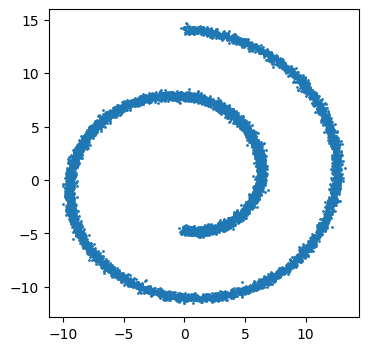

In [8]:
from sklearn.datasets import make_swiss_roll
import matplotlib.pyplot as plt

X, y = make_swiss_roll(n_samples = 10000, noise=0.2)
X = X[:, [0, 2]]

plt.figure(figsize=(4,4))
plt.scatter(X[:, 0], X[:, 1], s=1)

Next, we define our dataloader and training loop.

In [9]:
from torch.utils.data import TensorDataset, DataLoader

x0 = torch.tensor(X, dtype=torch.float32)
dataset = TensorDataset(x0)
loader = DataLoader(dataset, batch_size=512, shuffle=True)

device = "cuda" if torch.cuda.is_available() else "cpu"
T = 1000
betas = torch.linspace(1e-4, 2e-2, T, device=device)

model = DDPM(input_dims=2, denoising_steps=T, beta_schedule=betas, device=device).to(device)

optim = torch.optim.Adam(model.parameters(), lr=1e-3)

epochs = 150

for epoch in range(epochs):
    epoch_loss = 0.0
    n_batches = 0

    for (x0_batch,) in loader:
        x0_batch = x0_batch.to(device)

        eps, eps_theta = model(x0_batch)
        loss = model.compute_loss(eps, eps_theta)

        optim.zero_grad()
        loss.backward()
        optim.step()

        epoch_loss += loss.item()
        n_batches += 1

    if(epoch % 10 == 0):
        print(f"Epoch {epoch} | Loss {epoch_loss / n_batches:.6f}")

Epoch 0 | Loss 0.940609
Epoch 10 | Loss 0.587273
Epoch 20 | Loss 0.562510
Epoch 30 | Loss 0.516608
Epoch 40 | Loss 0.516219
Epoch 50 | Loss 0.495488
Epoch 60 | Loss 0.477856
Epoch 70 | Loss 0.462953
Epoch 80 | Loss 0.461216
Epoch 90 | Loss 0.462181
Epoch 100 | Loss 0.452558
Epoch 110 | Loss 0.467434
Epoch 120 | Loss 0.450593
Epoch 130 | Loss 0.451494
Epoch 140 | Loss 0.457429


Finally, we can sample from our network and visualise the generated data alongside the original data.

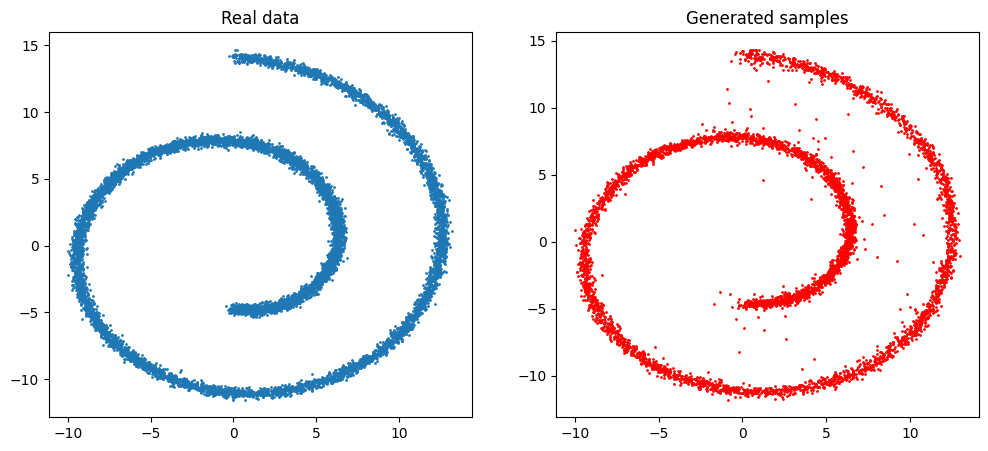

In [10]:
model.eval()

with torch.no_grad():
    samples = model.sample(n_samples=5000)
samples = samples.detach().cpu().numpy()

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(X[:, 0], X[:, 1], s=1)
plt.title("Real data")

plt.subplot(1, 2, 2)
plt.scatter(samples[:, 0], samples[:, 1], s=1, c='r')
plt.title("Generated samples")

plt.show()


### References
- Ho, J. et al. (2020). Denoising Diffusion Probabilistic Models ([arxiv](https://arxiv.org/abs/2006.11239))
- Murphy, K. P. (2023). Probabilistic Machine Learning: Advanced Topics, Chapter 25: Diffusion Models ([MIT Press](https://probml.github.io/pml-book/book2.html))
- Sohl-Dickstein, J. et al. (2015). Deep Unsupervised Learning using Nonequilibrium Thermodynamics ([arxiv](https://arxiv.org/abs/1503.03585))
